In [ ]:
!pip install -q datasets transformers accelerate sentencepiece

import os
import sys
import math
import json
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from dataclasses import dataclass
from typing import Optional, Tuple, Union, List
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("SYSTEM INFORMATION")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"\nGPU {i}: {props.name}")
        print(f"  Memory: {props.total_memory / 1024**3:.2f} GB")
        print(f"  Compute Capability: {props.major}.{props.minor}")
else:
    print("\nWARNING: No GPU detected, using CPU")

print("="*60)

In [2]:
import glob

existing_files = {
    'model': os.path.exists('/content/drive/MyDrive/Marathi_Stories_GPT/best_model.pt') or os.path.exists('/content/drive/MyDrive/Marathi_Stories_GPT/marathi_gpt_final.pt'),
    'data': os.path.exists('/content/drive/MyDrive/Marathi_Stories_GPT/train.bin') and os.path.exists('/content/drive/MyDrive/Marathi_Stories_GPT/validation.bin'),
    'config': os.path.exists('/content/drive/MyDrive/Marathi_Stories_GPT/model_config.json')
}

print("\n" + "="*60)
print("EXISTING FILES CHECK")
print("="*60)
for file_type, exists in existing_files.items():
    status = "Found" if exists else "Not found"
    print(f"{file_type.capitalize()}: {status}")

# User decision
if existing_files['model']:
    print("\n" + "="*60)
    print("TRAINING OPTIONS")
    print("="*60)
    print("A pre-trained model was found. What would you like to do?")
    print("1. Load existing model and continue training")
    print("2. Load existing model for inference only")
    print("3. Train a new model from scratch")
    print("4. Exit")

    while True:
        choice = input("\nEnter your choice (1/2/3/4): ").strip()
        if choice in ['1', '2', '3', '4']:
            USER_CHOICE = choice
            break
        print("Invalid choice. Please enter 1, 2, 3, or 4.")

    if USER_CHOICE == '4':
        print("Exiting...")
        sys.exit(0)
else:
    USER_CHOICE = '3'  # Train new model if none exists
    print("\nNo existing model found. Will train from scratch.")

print(f"\nSelected option: {USER_CHOICE}")
print("="*60)


EXISTING FILES CHECK
Model: Not found
Data: Not found
Config: Not found

No existing model found. Will train from scratch.

Selected option: 3


In [3]:
# Load and prepare dataset 
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer

if not existing_files['data'] or USER_CHOICE == '3':
    print("\nLoading and processing dataset...")

    # Load dataset
    full_ds = load_dataset("TinyStories-Regional/marathi-generated_4o-mini_2M")

    # Create train/validation split
    split = full_ds['train'].train_test_split(test_size=0.02, seed=42)
    ds = DatasetDict({
        'train': split['train'],
        'validation': split['test']
    })

    print("\nDataset splits:")
    print(ds)

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/marathi-gpt")
    vocab_size = len(tokenizer)
    print(f"\nVocabulary size: {vocab_size}")

    # Tokenization function
    def process(example):
        ids = tokenizer.encode(example['story'])
        return {'ids': ids, 'len': len(ids)}

    # Delete old files if they exist
    for filename in ['train.bin', 'validation.bin']:
        if os.path.exists(filename):
            os.remove(filename)
            print(f"Removed old {filename}")

    # Tokenize dataset
    print("\nTokenizing dataset...")
    tokenized = ds.map(
        process,
        remove_columns=['story', 'ID'],
        desc="Tokenizing",
        num_proc=min(8, os.cpu_count()),
    )

    # Save to binary files
    print("\nSaving tokenized data to binary files...")
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'Writing {filename}'):
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids'])
            arr[idx : idx + len(arr_batch)] = arr_batch
            idx += len(arr_batch)
        arr.flush()

    print("\nData preparation complete!")
else:
    print("\nUsing existing tokenized data files")
    tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/marathi-gpt")
    vocab_size = len(tokenizer)


Loading and processing dataset...


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

train.json:   0%|          | 0.00/6.10G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]


Dataset splits:
DatasetDict({
    train: Dataset({
        features: ['story', 'ID'],
        num_rows: 1960000
    })
    validation: Dataset({
        features: ['story', 'ID'],
        num_rows: 40000
    })
})


tokenizer_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]


Vocabulary size: 50257

Tokenizing dataset...


Tokenizing (num_proc=4):   0%|          | 0/1960000 [00:00<?, ? examples/s]

Tokenizing (num_proc=4):   0%|          | 0/40000 [00:00<?, ? examples/s]


Saving tokenized data to binary files...


Writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

Writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]


Data preparation complete!


In [4]:
@dataclass
class GPTConfig:
    """Configuration for GPT model"""
    block_size: int = 256      # Context window
    vocab_size: int = 50257    # Vocabulary size
    n_layer: int = 8           # Number of transformer layers
    n_head: int = 8            # Number of attention heads
    n_embd: int = 512          # Embedding dimension
    dropout: float = 0.1       # Dropout rate
    bias: bool = True          # Use bias in layers

class LayerNorm(nn.Module):
    """LayerNorm with optional bias"""
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention with Flash Attention support"""
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)

        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()

        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(
                q, k, v, attn_mask=None,
                dropout_p=self.dropout if self.training else 0.0,
                is_causal=True
            )
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    """Feed-Forward Network"""
    def __init__(self, config):
        super().__init__()
        hidden_dim = 4 * config.n_embd
        self.c_fc = nn.Linear(config.n_embd, hidden_dim, bias=config.bias)
        self.c_proj = nn.Linear(hidden_dim, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        self.activation = nn.GELU()

    def forward(self, x):
        x = self.activation(self.c_fc(x))
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    """Transformer block"""
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.ffn = FeedForward(config)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

class GPTModel(nn.Module):
    """GPT Language Model"""
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([TransformerBlock(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))

        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)

        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print(f"\nModel initialized with {self.get_num_params()/1e6:.2f}M parameters")

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Sequence length {t} exceeds block size {self.config.block_size}"

        pos = torch.arange(0, t, dtype=torch.long, device=device)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate_enhanced(self, idx, max_new_tokens, temperature=0.8, top_k=50, top_p=0.9,
                         repetition_penalty=1.2, no_repeat_ngram_size=3):
        """Enhanced text generation with coherence improvements"""
        generated_tokens = []

        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]

            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]

            # Apply repetition penalty
            if repetition_penalty != 1.0 and len(generated_tokens) > 0:
                for token_id in set(generated_tokens):
                    logits[:, token_id] /= repetition_penalty

            # Apply n-gram blocking
            if no_repeat_ngram_size > 0 and len(generated_tokens) >= no_repeat_ngram_size:
                prev_ngram = tuple(generated_tokens[-(no_repeat_ngram_size-1):])
                for token_id in range(self.config.vocab_size):
                    ngram = prev_ngram + (token_id,)
                    if ngram in [tuple(generated_tokens[i:i+no_repeat_ngram_size])
                                for i in range(len(generated_tokens)-no_repeat_ngram_size+1)]:
                        logits[:, token_id] = float('-inf')

            # Apply temperature
            logits = logits / temperature

            # Apply top-k filtering
            if top_k > 0:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')

            # Apply top-p filtering
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                logits[indices_to_remove] = float('-inf')

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)

            idx = torch.cat((idx, idx_next), dim=1)
            generated_tokens.append(idx_next.item())

        return idx

print("Model architecture defined")

Model architecture defined


In [5]:
# Data Loading Utilities

def get_batch(split, block_size, batch_size, device):
    """Get a batch of data for training"""
    data = np.memmap(f'{split}.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy(data[i:i+block_size].astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy(data[i+1:i+1+block_size].astype(np.int64)) for i in ix])

    if 'cuda' in device:
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)

    return x, y

print("Data loading utilities ready")

Data loading utilities ready


In [6]:
# Load config if it exists
if existing_files['config'] and USER_CHOICE in ['1', '2']:
    print("Loading existing configuration...")
    with open('/content/drive/MyDrive/Marathi_Stories_GPT/model_config.json', 'r') as f:
        config_dict = json.load(f)
    config = GPTConfig(**config_dict)
    print("Configuration loaded")
else:
    print("Creating new configuration...")
    config = GPTConfig(
        vocab_size=vocab_size,
        block_size=256,
        n_layer=8,
        n_head=8,
        n_embd=512,
        dropout=0.1,
        bias=True
    )
    print("Configuration created")

# Create model
model = GPTModel(config)

# Setup device and DataParallel
if torch.cuda.device_count() > 1:
    print(f"\nUsing {torch.cuda.device_count()} GPUs with DataParallel")
    model = DataParallel(model)
    device = 'cuda'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nUsing device: {device}")

model = model.to(device)

# Load existing weights if requested
if USER_CHOICE in ['1', '2'] and existing_files['model']:
    print("\nLoading model weights...")

    # Find the model file
    if os.path.exists('/content/drive/MyDrive/Marathi_Stories_GPT/best_model.pt'):
        model_path = '/content/drive/MyDrive/Marathi_Stories_GPT/best_model.pt'
    else:
        model_path = '/content/drive/MyDrive/Marathi_Stories_GPT/marathi_gpt_final.pt'

    try:
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)

        # Extract model state
        if 'model_state_dict' in checkpoint:
            model_state = checkpoint['model_state_dict']
        else:
            model_state = checkpoint

        # Load weights
        if hasattr(model, 'module'):
            model.module.load_state_dict(model_state)
        else:
            model.load_state_dict(model_state)

        print(f"Model loaded from {model_path}")

        # Print checkpoint info if available
        if isinstance(checkpoint, dict):
            if 'best_val_loss' in checkpoint:
                print(f"  Best validation loss: {checkpoint['best_val_loss']:.4f}")
            if 'train_losses' in checkpoint:
                print(f"  Training history: {len(checkpoint['train_losses'])} checkpoints")
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Continuing with random initialization...")

Creating new configuration...
Configuration created

Model initialized with 51.08M parameters

Using 2 GPUs with DataParallel


In [7]:
# Training Class

class Trainer:
    def __init__(self, model, config, device):
        self.model = model
        self.config = config
        self.device = device
        self.is_data_parallel = isinstance(model, DataParallel)

        # Training hyperparameters
        self.learning_rate = 3e-4
        self.min_lr = 1e-5
        self.warmup_steps = 1000
        self.max_iters = 20000
        self.eval_interval = 500
        self.eval_iters = 100
        self.batch_size = 12
        self.gradient_accumulation_steps = 4
        self.max_grad_norm = 1.0

        # Calculate effective batch size
        self.effective_batch_size = self.batch_size * self.gradient_accumulation_steps
        if torch.cuda.device_count() > 1 and self.is_data_parallel:
            self.effective_batch_size *= torch.cuda.device_count()

        print(f"\nTraining Configuration:")
        print(f"  Effective batch size: {self.effective_batch_size}")
        print(f"  Learning rate: {self.learning_rate}")
        print(f"  Max iterations: {self.max_iters}")
        print(f"  Using DataParallel: {self.is_data_parallel}")

        # Optimizer
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.learning_rate,
            betas=(0.9, 0.95),
            eps=1e-8,
            weight_decay=0.1
        )

        # Scheduler
        self.scheduler = CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=self.warmup_steps,
            T_mult=2,
            eta_min=self.min_lr
        )

        # Mixed precision
        self.use_amp = True and torch.cuda.is_available()
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)

        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.start_iter = 0

    @torch.no_grad()
    def estimate_loss(self):
        """Estimate loss on train and validation sets"""
        out = {}
        self.model.eval()

        for split in ['train', 'validation']:
            losses = []
            for k in range(self.eval_iters):
                X, Y = get_batch(split, self.config.block_size, self.batch_size, self.device)

                with torch.cuda.amp.autocast(enabled=self.use_amp):
                    _, loss = self.model(X, Y)

                    if self.is_data_parallel and loss.dim() > 0:
                        loss = loss.mean()

                    losses.append(loss.item())

            out[split] = np.mean(losses)

        self.model.train()
        return out

    def train(self, resume=False):
        """Main training loop"""
        print("\n" + "="*60)
        print("TRAINING STARTED")
        print("="*60)

        self.model.train()
        start_time = time.time()

        # Resume from checkpoint if requested
        if resume and hasattr(self, 'start_iter'):
            start_iter = self.start_iter
        else:
            start_iter = 0

        for iter_num in tqdm(range(start_iter, self.max_iters), desc="Training", initial=start_iter):

            # Evaluation
            if iter_num % self.eval_interval == 0 and iter_num > 0:
                losses = self.estimate_loss()
                elapsed = time.time() - start_time

                print(f"\n" + "="*60)
                print(f"Step {iter_num}/{self.max_iters} | Time: {elapsed:.1f}s")
                print(f"Train loss: {losses['train']:.4f} | Val loss: {losses['validation']:.4f}")
                print(f"Learning rate: {self.optimizer.param_groups[0]['lr']:.6f}")

                try:
                    perplexity = math.exp(min(losses['validation'], 10))
                    print(f"Perplexity: {perplexity:.2f}")
                except:
                    print("Perplexity: N/A")

                self.train_losses.append(losses['train'])
                self.val_losses.append(losses['validation'])

                # Save best model
                if losses['validation'] < self.best_val_loss:
                    self.best_val_loss = losses['validation']
                    self.save_checkpoint('best_model.pt')
                    print(f"Saved best model (val_loss: {self.best_val_loss:.4f})")

                print("="*60)

            # Training step
            self.optimizer.zero_grad(set_to_none=True)

            loss_accum = 0
            for micro_step in range(self.gradient_accumulation_steps):
                X, Y = get_batch('train', self.config.block_size, self.batch_size, self.device)

                with torch.cuda.amp.autocast(enabled=self.use_amp):
                    _, loss = self.model(X, Y)

                    if self.is_data_parallel and loss.dim() > 0:
                        loss = loss.mean()

                    loss = loss / self.gradient_accumulation_steps

                loss_accum += loss.item()
                self.scaler.scale(loss).backward()

            # Gradient clipping
            if self.max_grad_norm > 0:
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

            # Optimizer step
            self.scaler.step(self.optimizer)
            self.scaler.update()

            # Update learning rate
            self.scheduler.step()

            # Save current iteration
            self.start_iter = iter_num + 1

        print("\n" + "="*60)
        print("TRAINING COMPLETED")
        print("="*60)

        # Final evaluation
        final_losses = self.estimate_loss()
        print(f"\nFinal Results:")
        print(f"  Train loss: {final_losses['train']:.4f}")
        print(f"  Val loss: {final_losses['validation']:.4f}")

        try:
            perplexity = math.exp(min(final_losses['validation'], 10))
            print(f"  Perplexity: {perplexity:.2f}")
        except:
            print("  Perplexity: N/A")

        # Save final model
        self.save_checkpoint('marathi_gpt_final.pt')
        print("\n Final model saved")

    def save_checkpoint(self, path):
        """Save model checkpoint"""
        model_to_save = self.model.module if hasattr(self.model, 'module') else self.model

        checkpoint = {
            'model_state_dict': model_to_save.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'best_val_loss': self.best_val_loss,
            'start_iter': self.start_iter,
            'config_dict': {
                'vocab_size': self.config.vocab_size,
                'block_size': self.config.block_size,
                'n_layer': self.config.n_layer,
                'n_head': self.config.n_head,
                'n_embd': self.config.n_embd,
                'dropout': self.config.dropout,
                'bias': self.config.bias
            }
        }
        torch.save(checkpoint, path)

        # Also save config separately
        with open('model_config.json', 'w') as f:
            json.dump(checkpoint['config_dict'], f, indent=2)

    def load_checkpoint(self, path):
        """Load checkpoint for resuming training"""
        checkpoint = torch.load(path, map_location=self.device, weights_only=False)

        if hasattr(self.model, 'module'):
            self.model.module.load_state_dict(checkpoint['model_state_dict'])
        else:
            self.model.load_state_dict(checkpoint['model_state_dict'])

        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])
        self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        self.start_iter = checkpoint.get('start_iter', 0)

        print(f"Checkpoint loaded from {path}")
        print(f"Resuming from iteration: {self.start_iter}")
        print(f"Best validation loss: {self.best_val_loss:.4f}")

    def plot_losses(self):
        """Plot training and validation losses"""
        if not self.train_losses:
            print("No training data to plot")
            return

        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss', color='blue', alpha=0.7)
        plt.plot(self.val_losses, label='Val Loss', color='red', alpha=0.7)
        plt.xlabel(f'Steps (×{self.eval_interval})')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Perplexity plot
        plt.subplot(1, 2, 2)
        train_perp = [min(math.exp(loss), 1000) for loss in self.train_losses]
        val_perp = [min(math.exp(loss), 1000) for loss in self.val_losses]
        plt.plot(train_perp, label='Train Perplexity', color='blue', alpha=0.7)
        plt.plot(val_perp, label='Val Perplexity', color='red', alpha=0.7)
        plt.xlabel(f'Steps (×{self.eval_interval})')
        plt.ylabel('Perplexity')
        plt.title('Model Perplexity')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

print("Trainer class ready")

Trainer class ready



Training Configuration:
  Effective batch size: 96
  Learning rate: 0.0003
  Max iterations: 20000
  Using DataParallel: True

TRAINING STARTED


Training:   0%|          | 0/20000 [00:00<?, ?it/s]


Step 500/20000 | Time: 234.4s
Train loss: 3.9686 | Val loss: 3.9629
Learning rate: 0.000155
Perplexity: 52.61
Saved best model (val_loss: 3.9629)

Step 1000/20000 | Time: 469.1s
Train loss: 3.6221 | Val loss: 3.6627
Learning rate: 0.000300
Perplexity: 38.97
Saved best model (val_loss: 3.6627)

Step 1500/20000 | Time: 704.5s
Train loss: 3.3739 | Val loss: 3.3333
Learning rate: 0.000258
Perplexity: 28.03
Saved best model (val_loss: 3.3333)

Step 2000/20000 | Time: 939.7s
Train loss: 3.1245 | Val loss: 3.1457
Learning rate: 0.000155
Perplexity: 23.24
Saved best model (val_loss: 3.1457)

Step 2500/20000 | Time: 1175.3s
Train loss: 3.0649 | Val loss: 3.0415
Learning rate: 0.000052
Perplexity: 20.94
Saved best model (val_loss: 3.0415)

Step 3000/20000 | Time: 1410.8s
Train loss: 3.0246 | Val loss: 2.9981
Learning rate: 0.000300
Perplexity: 20.05
Saved best model (val_loss: 2.9981)

Step 3500/20000 | Time: 1646.3s
Train loss: 3.0479 | Val loss: 3.0713
Learning rate: 0.000289
Perplexity: 21.5

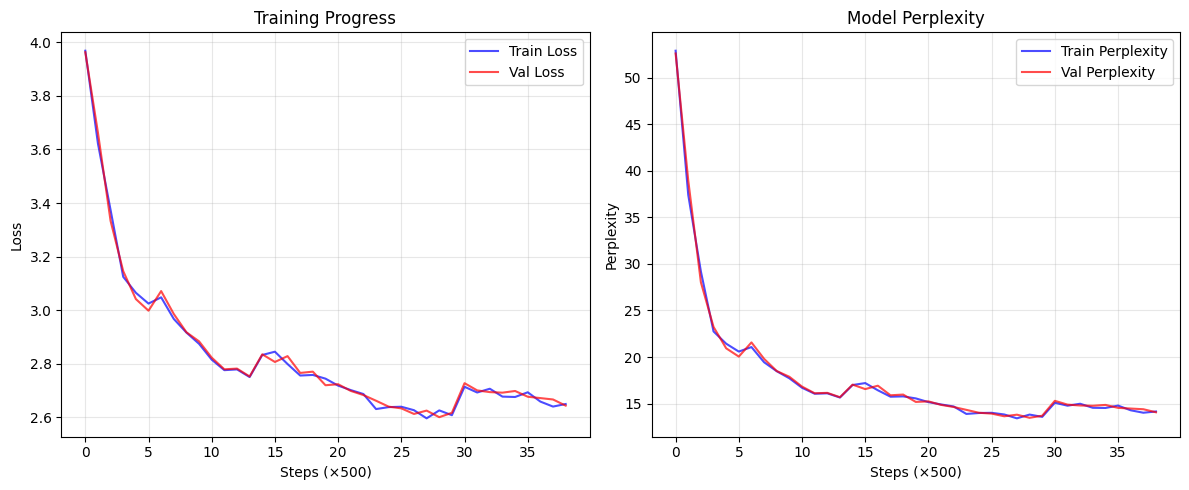

In [8]:
if USER_CHOICE in ['1', '3']:  # Train or continue training
    trainer = Trainer(model, config, device)

    if USER_CHOICE == '1' and os.path.exists('/content/Model/best_model.pt'):
        # Continue training from checkpoint
        print("\nLoading checkpoint for continued training...")
        trainer.load_checkpoint('/content/Model/best_model.pt')
        trainer.train(resume=True)
    else:
        # Train from scratch
        trainer.train(resume=False)

    # Plot training progress
    trainer.plot_losses()

elif USER_CHOICE == '2':
    print("\n Model loaded for inference only")
    print("Skipping training phase...")

    # Create trainer instance for later use (without training)
    trainer = Trainer(model, config, device)
    if os.path.exists('/content/Model/best_model.pt'):
        # Load training history if available
        try:
            checkpoint = torch.load('/content/Model/best_model.pt', map_location=device, weights_only=False)
            trainer.train_losses = checkpoint.get('train_losses', [])
            trainer.val_losses = checkpoint.get('val_losses', [])
            trainer.best_val_loss = checkpoint.get('best_val_loss', float('inf'))

            if trainer.train_losses:
                print(f"\nTraining History:")
                print(f"  Training steps: {len(trainer.train_losses) * trainer.eval_interval}")
                print(f"  Best val loss: {trainer.best_val_loss:.4f}")

                # Optionally plot existing training history
                plot_choice = input("\nPlot training history? (y/n): ").strip().lower()
                if plot_choice == 'y':
                    trainer.plot_losses()
        except:
            pass

In [9]:
# Text Generation Utilities

class TextGenerator:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

        # Handle DataParallel
        if hasattr(model, 'module'):
            self.model_core = model.module
        else:
            self.model_core = model

    def generate(self, prompt, max_length=200, temperature=0.8, top_k=50, top_p=0.9,
                repetition_penalty=1.2, no_repeat_ngram_size=3, num_return_sequences=1):
        """Generate coherent text from prompt"""

        self.model.eval()
        results = []

        with torch.no_grad():
            for _ in range(num_return_sequences):
                # Encode prompt
                input_ids = torch.tensor(
                    self.tokenizer.encode(prompt),
                    device=self.device
                ).unsqueeze(0)

                # Generate
                output = self.model_core.generate_enhanced(
                    input_ids,
                    max_new_tokens=max_length,
                    temperature=temperature,
                    top_k=top_k,
                    top_p=top_p,
                    repetition_penalty=repetition_penalty,
                    no_repeat_ngram_size=no_repeat_ngram_size
                )

                # Decode
                generated_text = self.tokenizer.decode(
                    output[0].tolist(),
                    skip_special_tokens=True
                )
                results.append(generated_text)

        return results

    def beam_search(self, prompt, beam_width=3, max_length=200):
        """Generate using beam search for more coherent output"""
        self.model.eval()

        input_ids = torch.tensor(
            self.tokenizer.encode(prompt),
            device=self.device
        ).unsqueeze(0)

        beams = [(input_ids, 0.0)]

        with torch.no_grad():
            for _ in range(max_length):
                candidates = []

                for seq, score in beams:
                    if seq.size(1) > self.model_core.config.block_size:
                        seq = seq[:, -self.model_core.config.block_size:]

                    logits, _ = self.model(seq)
                    logits = logits[:, -1, :]

                    probs = F.softmax(logits, dim=-1)
                    topk_probs, topk_indices = torch.topk(probs, beam_width)

                    for i in range(beam_width):
                        new_seq = torch.cat([seq, topk_indices[:, i:i+1]], dim=1)
                        new_score = score + torch.log(topk_probs[:, i]).item()
                        candidates.append((new_seq, new_score))

                candidates.sort(key=lambda x: x[1], reverse=True)
                beams = candidates[:beam_width]

        best_seq = beams[0][0]
        return self.tokenizer.decode(best_seq[0].tolist(), skip_special_tokens=True)

    def interactive_generate(self):
        """Interactive text generation interface"""
        print("\n" + "="*60)
        print("INTERACTIVE TEXT GENERATION")
        print("="*60)
        print("Type 'quit' to exit, 'help' for options")
        print("="*60)

        while True:
            prompt = input("\nPrompt > ").strip()

            if prompt.lower() == 'quit':
                break
            elif prompt.lower() == 'help':
                print("\nOptions:")
                print("  Temperature: Controls randomness (0.1-1.0)")
                print("  Max length: Maximum tokens to generate")
                print("  Method: 'sample' or 'beam' search")
                continue
            elif not prompt:
                continue

            # Get generation parameters
            print("\nGeneration settings (press Enter for defaults):")
            temp = float(input("  Temperature (0.8): ") or 0.8)
            max_len = int(input("  Max length (200): ") or 200)
            method = input("  Method [sample/beam] (sample): ") or 'sample'

            print("\nGenerating...", end="")

            if method == 'beam':
                result = self.beam_search(prompt, beam_width=3, max_length=max_len)
            else:
                results = self.generate(
                    prompt,
                    max_length=max_len,
                    temperature=temp,
                    repetition_penalty=1.3,
                    no_repeat_ngram_size=3
                )
                result = results[0]

            print(" Done!")
            print("\n" + "="*60)
            print("GENERATED TEXT:")
            print("="*60)
            print(result)
            print("="*60)

# Create generator
generator = TextGenerator(model, tokenizer, device)
print("Text generator ready")

Text generator ready


In [10]:
# Test Generation with Example Prompts

test_prompts = [
    "एकदा एका जंगलात एक लहान वाघ होता",
    "एकदा एका तळ्यात बदके होती",
    "एकदा राजा आणि राणी शिकारीला निघाले",
    "एकदा चिनू नावाचा एक मुलगा होता",
    "एकदा हत्ती आणि मुंगी यांची शर्यत लागली",
    "एक गाव होतं जिथे सगळे लोक"
]

print("\n" + "="*70)
print("TEXT GENERATION EXAMPLES")
print("="*70)

for i, prompt in enumerate(test_prompts[:5], 1):
    print(f"\nExample {i}:")
    print(f"PROMPT: {prompt}")
    print("-"*50)

    generated = generator.generate(
        prompt,
        max_length=150,
        temperature=0.75,
        top_k=40,
        top_p=0.9,
        repetition_penalty=1.3,
        no_repeat_ngram_size=3
    )

    print("GENERATED:")
    print(generated[0])
    print("="*70)

print("\nGeneration test complete")


TEXT GENERATION EXAMPLES

Example 1:
PROMPT: एकदा एका जंगलात एक लहान वाघ होता
--------------------------------------------------
GENERATED:
एकदा एका जंगलात एक लहान वाघ होता . त्याचे नाव होते ' चिं की '. चिं कीला जंगलातील सर्व प्राणी आवडत असत . तो नेहमी आपल्या मित्रांसोबत खेळत असे आणि त्यांना आनंद देत असे . एक दिवस , जंगलात एक मोठा उत्सव झाला . त्या उत्सवात सर्व प्राण्या ंनी एकत्र येऊन गाणी गाणे सुरू केले . चिं कीने त्याच्या मित्रांना सांगितले , " आपण सर्वांनी मिळून नाच णे आवश्यक आहे !" पण प्राण्यांना हे ऐकून थोडं भीती वाटलं . त्यांनी ठरवलं की ते एकत्र येतील आणि एकमेकांना मदत करतील . चिं कीच्या मित्रांनी त्याला धीर दिला . त्यांनी एकत्रितपणे नाचा यला सुरुवात केली . त्यांचा उत्साह पाहून सर्व प्राण्यांचे हृदय स्पर्शी भावना वाढले . चिं की नेही त्यांच्यात सामील होणे सुरू ठेवले . उत्सवाच्या दिवशी , जंगल रंगीत झाले . लोक आनंदाने नाचत होते आणि गात होते . चिं कीला खूप मजा आली . त्याने विचार केला , " माझ्या मित्रांच्या मदती मुळे हा उत्सव किती सुंदर

Example 2:
PROMPT: एकदा एका तळ्यात बदके होती
-

In [11]:
# Save Final Model and Summary

print("\n" + "="*60)
print("MODEL SUMMARY & EXPORT")
print("="*60)

# Save final model if not already saved
model_to_save = model.module if hasattr(model, 'module') else model

# Save model weights
if not os.path.exists('marathi_gpt_final.pt'):
    torch.save(model_to_save.state_dict(), 'marathi_gpt_final.pt')
    print("Model saved to marathi_gpt_final.pt")
else:
    print("Model already saved")

# Save configuration
config_dict = {
    'vocab_size': config.vocab_size,
    'block_size': config.block_size,
    'n_layer': config.n_layer,
    'n_head': config.n_head,
    'n_embd': config.n_embd,
    'dropout': config.dropout,
    'bias': config.bias,
    'model_params': model_to_save.get_num_params()
}

with open('model_config.json', 'w') as f:
    json.dump(config_dict, f, indent=2)

print("Configuration saved to model_config.json")

# Print summary
print("\n" + "="*60)
print("MODEL STATISTICS")
print("="*60)
print(f"Architecture: GPT")
print(f"Parameters: {model_to_save.get_num_params()/1e6:.2f}M")
print(f"Layers: {config.n_layer}")
print(f"Heads: {config.n_head}")
print(f"Embedding dim: {config.n_embd}")
print(f"Context length: {config.block_size}")
print(f"Vocabulary size: {config.vocab_size}")

if hasattr(trainer, 'best_val_loss') and trainer.best_val_loss < float('inf'):
    print(f"\nTraining Results:")
    print(f"  Best validation loss: {trainer.best_val_loss:.4f}")
    try:
        print(f"  Best perplexity: {math.exp(trainer.best_val_loss):.2f}")
    except:
        pass

print("\n" + "="*60)
print("ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*60)
print("\nYour Marathi language model is ready for use.")
print("Files created:")
print("  • marathi_gpt_final.pt - Model weights")
print("  • model_config.json - Model configuration")
print("  • best_model.pt - Best checkpoint (if trained)")
print("\nThank you for using this notebook!")


MODEL SUMMARY & EXPORT
Model already saved
Configuration saved to model_config.json

MODEL STATISTICS
Architecture: GPT
Parameters: 51.08M
Layers: 8
Heads: 8
Embedding dim: 512
Context length: 256
Vocabulary size: 50257

Training Results:
  Best validation loss: 2.6005
  Best perplexity: 13.47

ALL TASKS COMPLETED SUCCESSFULLY!

Your Marathi language model is ready for use.
Files created:
  • marathi_gpt_final.pt - Model weights
  • model_config.json - Model configuration
  • best_model.pt - Best checkpoint (if trained)

Thank you for using this notebook!
